Propriety of Ludovic Morin 

In [2]:
pip install python-louvain

Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn.cluster import MiniBatchKMeans, Birch
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csr_matrix, diags
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.loader import NeighborSampler
from torch_geometric.data import Data
from tqdm import tqdm
import os
import hdbscan
import community as community_louvain
from networkx.algorithms.community.quality import modularity
import random
from collections import deque

In [4]:
def load_hyperlink_data():
    title_links = pd.read_csv("soc-redditHyperlinks-title.tsv", sep='\t')
    body_links = pd.read_csv("soc-redditHyperlinks-body.tsv", sep='\t')
    df = pd.concat([title_links, body_links], ignore_index=True)
    df = df[['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT']]
    G = nx.from_pandas_edgelist(df, source='SOURCE_SUBREDDIT', target='TARGET_SUBREDDIT')
    adjacency = nx.to_scipy_sparse_array(G, format='csr')
    print("link network built")
    return G, adjacency, list(G.nodes())

def extract_graph_features(G):
    print("Calculating Network Features...")
    degrees = np.array([val for _, val in G.degree()]).reshape(-1, 1)
    clustering = np.array([val for _, val in nx.clustering(G).items()]).reshape(-1, 1)
    pagerank = np.array([val for _, val in nx.pagerank(G).items()]).reshape(-1, 1)
    betweenness_dict = nx.betweenness_centrality(G,k=50)  #smaller k= faster but less accurate
    betweenness = np.array([betweenness_dict[n] for n in G.nodes()]).reshape(-1, 1)
    #closeness_dict = nx.closeness_centrality(G)
    #closeness = np.array([closeness_dict[n] for n in G.nodes()]).reshape(-1, 1)
    features = np.hstack([degrees, clustering, pagerank,betweenness])
    features = StandardScaler().fit_transform(features)
    print("Features Calculation Complete!")
    return features

def load_user_embeddings():
    user_embeddings = pd.read_csv("web-redditEmbeddings-users.csv")
    node_names = user_embeddings.iloc[:, 0].tolist()
    raw_features = user_embeddings.iloc[:, 1:].values
    
    scaled_features = StandardScaler().fit_transform(raw_features)
    knn_adj = kneighbors_graph(scaled_features, n_neighbors=10, mode='connectivity', include_self=False)
    G = nx.from_scipy_sparse_array(knn_adj)
    
    pagerank_dict = nx.pagerank(G)
    pagerank_values = np.array([pagerank_dict[i] for i in range(len(node_names))]).reshape(-1, 1)
    adjacency = knn_adj
    return G, adjacency, node_names

def load_subreddit_embeddings(): 
    subreddit_embeddings = pd.read_csv("web-redditEmbeddings-subreddits.csv")
    node_names = subreddit_embeddings.iloc[:, 0].tolist()
    raw_features = subreddit_embeddings.iloc[:, 1:].values
    scaled_features = StandardScaler().fit_transform(raw_features)

    knn_adj = kneighbors_graph(scaled_features, n_neighbors=10, mode='connectivity', include_self=False)
    G = nx.from_scipy_sparse_array(knn_adj)
    pagerank_dict = nx.pagerank(G)
    pagerank_values = np.array([pagerank_dict[i] for i in range(len(node_names))]).reshape(-1, 1)
    adjacency = knn_adj
    return G, adjacency, node_names

def build_adj_dict(G):
    """
    Returns:
      adj_dict: dict[node] -> list of neighbors
      node_list: list of all nodes in G
    """
    node_list = list(G.nodes())
    adj_dict = {}
    for n in node_list:
        adj_dict[n] = list(G.neighbors(n))
    return adj_dict, node_list
def build_dummy_features(num_nodes):
    """
    Creates a 2D array [n, 1] of all ones,
    so each node has a 1D feature. 
    """
    return np.ones((num_nodes, 1), dtype=np.float32)


In [5]:
def hdbscan_clustering(features, min_cluster_size=10):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, core_dist_n_jobs=-1)
    return clusterer.fit_predict(features)

def kmeans_clustering(embeddings, num_clusters):
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42, batch_size=1000)
    return kmeans.fit_predict(embeddings)

def birch_clustering(features, num_clusters):
    birch_model = Birch(n_clusters=num_clusters, threshold=1.5)
    return birch_model.fit_predict(features)

def louvain_clustering(G):
    partition = community_louvain.best_partition(G)
    node_list = list(G.nodes())
    labels = [partition[node] for node in node_list]
    return labels

In [ ]:
class DMoN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_clusters):
        super(DMoN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_clusters)
        self.num_clusters = num_clusters

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.softmax(x, dim=1)

def to_edge_index(adj_matrix):
    rows, cols = adj_matrix.nonzero()
    edge_index = torch.tensor(np.vstack((rows, cols)), dtype=torch.long)
    return edge_index

def normalize_adjacency(adj_matrix):
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degrees = np.maximum(degrees, 1e-12)
    d_inv_sqrt = 1.0 / np.sqrt(degrees)
    D_inv_sqrt = diags(d_inv_sqrt)
    return D_inv_sqrt @ adj_matrix @ D_inv_sqrt

def dmon_loss(cluster_assignments, adj_normalized, num_clusters, collapse_regularization=1.0):
    A_norm = adj_normalized.tocoo()
    indices = torch.tensor([A_norm.row, A_norm.col], dtype=torch.long)
    values = torch.tensor(A_norm.data, dtype=torch.float32)
    A_sparse = torch.sparse_coo_tensor(indices, values, A_norm.shape)
    CTC = torch.matmul(cluster_assignments.t(), torch.sparse.mm(A_sparse, cluster_assignments))
    trace_term = torch.trace(CTC)
    n = cluster_assignments.shape[0]
    ones = torch.ones(n, 1, dtype=torch.float32)
    identity = torch.eye(num_clusters, dtype=torch.float32)
    collapse_term = torch.norm(cluster_assignments.t() @ ones - identity, p='fro')**2
    loss = -0.5 * trace_term + (collapse_regularization * num_clusters / n) * collapse_term
    return loss

def train_dmon(features, adj_matrix, num_clusters, hidden_channels=8, lr=0.1, epochs=100):
    print(torch.cuda.is_available())
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    x = torch.tensor(features, dtype=torch.float32).to(device)
    edge_index = to_edge_index(adj_matrix).to(device)
    model = DMoN(features.shape[1], hidden_channels, num_clusters).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    adj_normalized = normalize_adjacency(adj_matrix)
    model.train()
    losses = []
    for epoch in tqdm(range(epochs), desc="Training DMoN"):
        optimizer.zero_grad()
        cluster_assignments = model(x, edge_index)
        loss = dmon_loss(cluster_assignments, adj_normalized, num_clusters).to(device)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    model.eval()
    with torch.no_grad():
        cluster_assignments = model(x, edge_index)
    labels = torch.argmax(cluster_assignments, dim=1).cpu().numpy()
    return labels, model, losses

class DMoN_SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_clusters):
        super(DMoN_SAGE, self).__init__()
        #graphsage
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, num_clusters)
        self.num_clusters = num_clusters

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.softmax(x, dim=1)
    
#graph version of DMoN

class DMoN_SAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_clusters):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, num_clusters)
        self.num_clusters = num_clusters

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.softmax(x, dim=1)

def dmon_loss_subgraph(cluster_assign, sub_adj_norm, num_clusters, collapse_reg=1.0):
    A = sub_adj_norm.tocoo()
    device = cluster_assign.device
    row = torch.tensor(A.row, dtype=torch.long, device=device)
    col = torch.tensor(A.col, dtype=torch.long, device=device)
    vals = torch.tensor(A.data, dtype=torch.float32, device=device)
    A_sp = torch.sparse_coo_tensor(torch.stack([row, col]), vals, A.shape).coalesce()

    CTC = cluster_assign.t() @ (A_sp @ cluster_assign)
    trace_val = torch.trace(CTC)

    n = cluster_assign.size(0)
    ones = torch.ones(n, 1, device=device)
    eye_c = torch.eye(num_clusters, device=device)
    collapse_term = torch.norm(cluster_assign.t() @ ones - eye_c, p='fro')**2

    loss = -0.5 * trace_val + (collapse_reg * num_clusters / n) * collapse_term
    return loss

def sample_subgraph(
    G, center_nodes, node2idx, features,
    num_hops=1,
    max_neighbors=10
):
    visited = set()
    queue = deque()
    for cn in center_nodes:
        visited.add(cn)
        queue.append((cn, 0))

    while queue:
        current, depth = queue.popleft()
        if depth < num_hops:
            neighbors = list(G.neighbors(current))
            # random sample neighbors to keep subgraph small
            if len(neighbors) > max_neighbors:
                neighbors = random.sample(neighbors, max_neighbors)
            for nei in neighbors:
                if nei not in visited:
                    visited.add(nei)
                    queue.append((nei, depth + 1))

    sub_mapping = sorted(visited, key=lambda n: node2idx[n])
    sub_idx_map = {nid: i for i, nid in enumerate(sub_mapping)}

    edges = []
    for nid in sub_mapping:
        for nei in G[nid]:
            if nei in sub_idx_map:
                edges.append((sub_idx_map[nid], sub_idx_map[nei]))

    # handle empty edges
    edges_array = np.array(edges).T if edges else np.empty((2,0), dtype=int)
    sub_edge_index = torch.tensor(edges_array, dtype=torch.long)

    sub_x = features[[node2idx[n] for n in sub_mapping], :]
    sub_x = torch.tensor(sub_x, dtype=torch.float32)
    return sub_x, sub_edge_index, sub_mapping

def build_sub_adj_norm(sub_edge_index, sub_size):
    if sub_edge_index.size(1) == 0:
        return csr_matrix((sub_size, sub_size), dtype=np.float32)
    rows = sub_edge_index[0].cpu().numpy()
    cols = sub_edge_index[1].cpu().numpy()
    data = np.ones(rows.shape[0], dtype=np.float32)
    mat = csr_matrix((data, (rows, cols)), shape=(sub_size, sub_size))
    degs = np.array(mat.sum(axis=1)).flatten()
    degs = np.maximum(degs, 1e-12)
    inv = 1.0 / degs
    D_inv = csr_matrix(np.diag(inv))
    return D_inv @ mat

def train_dmon_graph_mixed(
    G,
    features,         # shape [n, d], e.g. from extract_graph_features(G)
    num_clusters,
    hidden_channels=32,
    lr=0.01,
    epochs=40,
    collapse_reg=1.0,
    batch_size=1024,
    num_hops=1,         #default BFS depth = 1
    max_neighbors=10    #smaller neighbor cap
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    node_list = list(G.nodes())
    node2idx = {n: i for i, n in enumerate(node_list)}
    n = len(node_list)

    in_channels = features.shape[1]
    model = DMoN_SAGE(in_channels, hidden_channels, num_clusters).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []

    model.train()
    for epoch in range(epochs):
        random.shuffle(node_list)
        total_loss = 0.0
        num_batches = 0

        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            batch_nodes = node_list[start:end]

            sub_x, sub_edge_index, sub_mapping = sample_subgraph(
                G, batch_nodes, node2idx, features,
                num_hops=num_hops, max_neighbors=max_neighbors
            )
            sub_x = sub_x.to(device)
            sub_edge_index = sub_edge_index.to(device)

            cluster_assign = model(sub_x, sub_edge_index)
            sub_adj_norm = build_sub_adj_norm(sub_edge_index, sub_x.size(0))

            loss = dmon_loss_subgraph(cluster_assign, sub_adj_norm, num_clusters, collapse_reg)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        avg_loss = total_loss / max(num_batches, 1)
        losses.append(avg_loss)
        if epoch % 5 == 0:
            print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

    model.eval()
    final_labels = np.zeros(n, dtype=np.int64)
    with torch.no_grad():
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            batch_nodes = node_list[start:end]

            sub_x, sub_edge_index, sub_mapping = sample_subgraph(
                G, batch_nodes, node2idx, features,
                num_hops=num_hops, max_neighbors=max_neighbors
            )
            sub_x = sub_x.to(device)
            sub_edge_index = sub_edge_index.to(device)

            out = model(sub_x, sub_edge_index)
            preds = torch.argmax(out, dim=1).cpu().numpy()
            for i, node_id in enumerate(sub_mapping):
                if node_id in batch_nodes:
                    final_labels[node2idx[node_id]] = preds[i]

    return final_labels, model, losses


def train_dmon_graph(
    G, num_clusters, hidden_channels=32, lr=0.01, epochs=40, collapse_reg=1.0,
    batch_size=1024, num_hops=2, max_neighbors=25
):
    """
    G: NetworkX graph
    num_clusters: how many clusters
    We do BFS-based sampling in mini-batches of nodes, then build subgraphs.

    Returns:
      final_labels: np.array of shape [n,]
      model: the trained DMoN_SAGE
      losses: list of training losses (avg per epoch)
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    node_list = list(G.nodes())
    node2idx = {n: i for i, n in enumerate(node_list)}
    n = len(node_list)
    features = np.ones((n, 1), dtype=np.float32)

    in_channels = features.shape[1]
    model = DMoN_SAGE(in_channels, hidden_channels, num_clusters).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []

    model.train()
    for epoch in range(epochs):
        random.shuffle(node_list)
        total_loss = 0
        num_batches = 0
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            batch_nodes = node_list[start:end]

            sub_x, sub_edge_index, sub_mapping = sample_subgraph(
                G, batch_nodes, node2idx, features,
                num_hops=num_hops, max_neighbors=max_neighbors
            )
            sub_x = sub_x.to(device)
            sub_edge_index = sub_edge_index.to(device)

            cluster_assignments = model(sub_x, sub_edge_index)

            sub_adj_norm = build_sub_adj_norm(sub_edge_index, sub_x.size(0))

            loss = dmon_loss_subgraph(cluster_assignments, sub_adj_norm, num_clusters, collapse_reg)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        avg_loss = total_loss / (num_batches if num_batches>0 else 1)
        losses.append(avg_loss)
        if epoch % 5 == 0:
            print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

    model.eval()
    final_assignments = np.zeros((n,), dtype=np.int64)

    with torch.no_grad():
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            batch_nodes = node_list[start:end]

            sub_x, sub_edge_index, sub_mapping = sample_subgraph(
                G, batch_nodes, node2idx, features,
                num_hops=num_hops, max_neighbors=max_neighbors
            )
            sub_x = sub_x.to(device)
            sub_edge_index = sub_edge_index.to(device)

            out = model(sub_x, sub_edge_index)
            preds = torch.argmax(out, dim=1).cpu().numpy()
            for i, node_id in enumerate(sub_mapping):
                if node_id in batch_nodes:
                    final_assignments[node2idx[node_id]] = preds[i]

    return final_assignments, model, losses


def evaluate_clustering(true_labels, pred_labels):
    ami = adjusted_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    return {"AMI": ami, "ARI": ari}

def export_gml(graph, labels, node_names, filename):
    mapping = {node: str(name) for node, name in zip(graph.nodes(), node_names)}
    G_labeled = nx.relabel_nodes(graph, mapping)
    for name, label in zip(node_names, labels):
        G_labeled.nodes[str(name)]["cluster"] = int(label)
        G_labeled.nodes[str(name)]["label"] = str(name)
    nx.write_gml(G_labeled, filename)

def export_louvain_to_gml(G, partition, filename="louvain_communities.gml"):
    for node, community_id in partition.items():
        G.nodes[node]["louvain_comm"] = community_id
    nx.write_gml(G, filename)

def plot_loss(losses, title):
    plt.figure(figsize=(12, 8))
    plt.plot(losses, label="DMoN Loss", color='blue')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [23]:
def compute_modularity(G,labels):
    node_list=list(G.nodes())
    partition_dict={}
    for i,n in enumerate(node_list):
        c=labels[i]
        partition_dict.setdefault(c,set()).add(n)
    csets=list(partition_dict.values())
    return modularity(G,csets)
def compute_conductance(G,labels):
    node_list=list(G.nodes())
    partition_dict={}
    for i,n in enumerate(node_list):
        c=labels[i]
        partition_dict.setdefault(c,set()).add(n)
    deg=dict(G.degree())
    tc=0.0
    nc=len(partition_dict)
    for c_id,members in partition_dict.items():
        vs=sum(deg[n]for n in members)
        vsm=sum(deg[x]for x in G.nodes()if x not in members)
        ec=0
        for node in members:
            for nei in G[node]:
                if nei not in members:
                    ec+=1
        d=min(vs,vsm)
        tc+=0 if d==0 else ec/d
    return tc/nc if nc>0 else 0



In [8]:
if __name__ == "__main__":    
    G, adjacency, hyperlink_nodes = load_hyperlink_data()
    structural_features = extract_graph_features(G)
    print("Hyperlink Adjacancy shape:", adjacency.shape)
    
    num_clusters = 20
    kmeans_labels = kmeans_clustering(structural_features, num_clusters)
    hdbscan_labels = hdbscan_clustering(structural_features,min_cluster_size=10)
    louvain_labels = louvain_clustering(G)

    dmon_labels, dmon_model, loss_history = train_dmon(structural_features, adjacency, num_clusters,epochs=41)
    dmon_mixed_labels, dmon_mixed_model, dmon_mixed_losses = train_dmon_graph_mixed(G, structural_features,num_clusters,epochs=40)


link network built
Calculating Network Features...
Features Calculation Complete!
Hyperlink Adjacancy shape: (67180, 67180)


c:\Users\Proprio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


False


Training DMoN:   0%|          | 0/41 [00:00<?, ?it/s]C:\Users\Proprio\AppData\Local\Temp\ipykernel_9992\2386586383.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  indices = torch.tensor([A_norm.row, A_norm.col], dtype=torch.long)
Training DMoN:   2%|▏         | 1/41 [00:00<00:19,  2.06it/s]

Epoch 0, Loss: 1383985.2500


Training DMoN:  51%|█████     | 21/41 [00:10<00:09,  2.01it/s]

Epoch 20, Loss: 1344455.3750


Training DMoN: 100%|██████████| 41/41 [00:20<00:00,  2.00it/s]

Epoch 40, Loss: 1343142.8750


Epoch 0, Loss: 77425.3848
Epoch 5, Loss: 60174.3793
Epoch 10, Loss: 60205.4754
Epoch 15, Loss: 60187.5459
Epoch 20, Loss: 60250.2373
Epoch 25, Loss: 60157.7637
Epoch 30, Loss: 60116.7302
Epoch 35, Loss: 60110.6723


In [ ]:
print("Hyperlink Network Results")
print("DMoN vs. Louvain:", evaluate_clustering(dmon_labels, louvain_labels))
print("Mixed DMoN vs. Louvain:", evaluate_clustering(dmon_mixed_labels, louvain_labels))
print("Mixed DMoN vs. DMoN:", evaluate_clustering(dmon_mixed_labels, dmon_labels))

Hyperlink Network Results
DMoN vs. Louvain: {'AMI': 0.02896280544535643, 'ARI': 0.006271718701220818}
Graph DMoN vs. Louvain: {'AMI': 0.09134541538151056, 'ARI': 0.02988855350655903}
Mixed DMoN vs. DMoN: {'AMI': 0.011410488038808425, 'ARI': 0.005192564862525813}


In [ ]:
kmeans_mod   = compute_modularity(G, kmeans_labels)
kmeans_cond  = compute_conductance(G, kmeans_labels)

hdbscan_mod  = compute_modularity(G, hdbscan_labels)
hdbscan_cond = compute_conductance(G, hdbscan_labels)

dmon_mod     = compute_modularity(G, dmon_labels)
dmon_cond    = compute_conductance(G, dmon_labels)

#graph_dmon_mod  = compute_modularity(G, dmon_graph_labels)
#graph_dmon_cond = compute_conductance(G, dmon_graph_labels)

mixed_dmon_mod  = compute_modularity(G, dmon_mixed_labels)
mixed_dmon_cond = compute_conductance(G, dmon_mixed_labels)

lou_mod      = compute_modularity(G, louvain_labels)
lou_cond     = compute_conductance(G, louvain_labels)

# Collect everything into a list of rows:
rows = [
    ["K-means",   kmeans_mod,   kmeans_cond      ],
    ["HDBSCAN",   hdbscan_mod,  hdbscan_cond     ],
    ["DMoN",      dmon_mod,     dmon_cond        ],
#    ["GraphDMoN", graph_dmon_mod, graph_dmon_cond],
    ["Mixed DMoN", mixed_dmon_mod, mixed_dmon_cond],
    ["Louvain",   lou_mod,      lou_cond,        ]
]

df_results = pd.DataFrame(rows, columns=["Method", "Modularity","Conductance"])

print(df_results)

       Method  Modularity  Conductance
0     K-means   -0.018125     0.933670
1     HDBSCAN   -0.009986     0.995100
2        DMoN    0.000969     0.929787
3  Mixed DMoN    0.037429     0.893178
4     Louvain    0.416018     0.020955


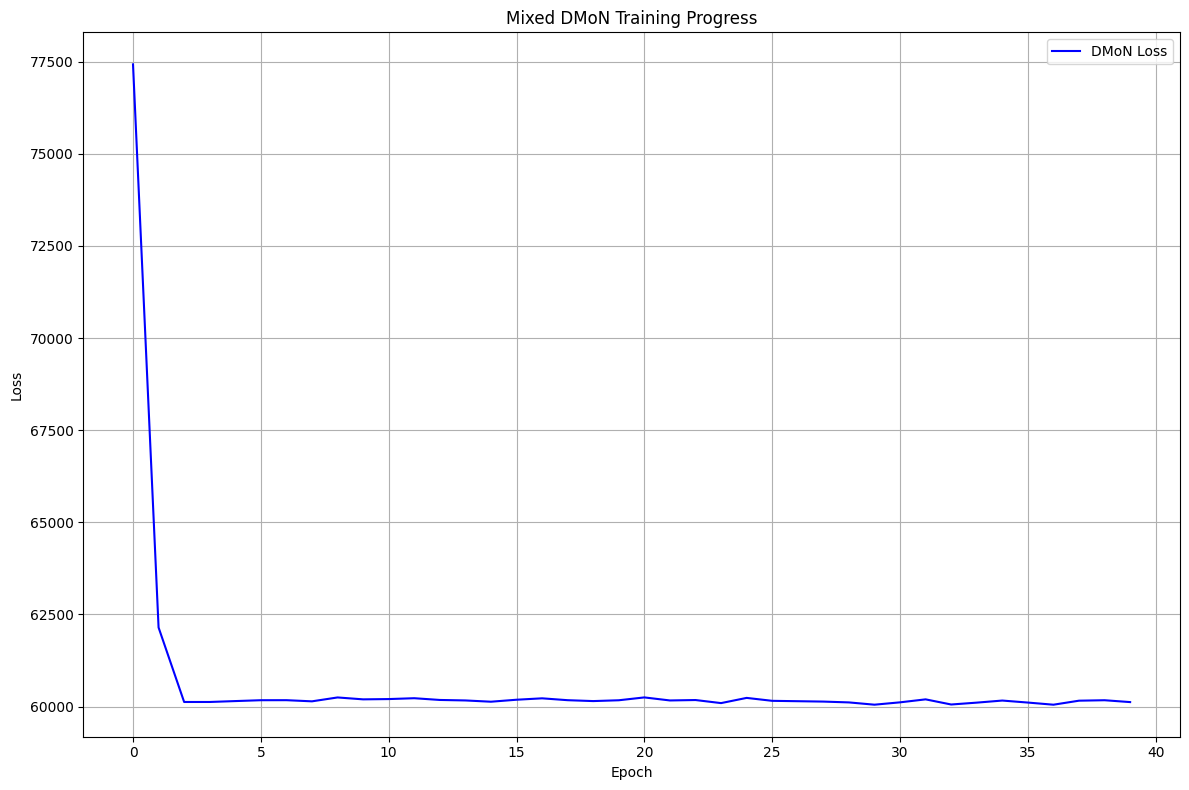

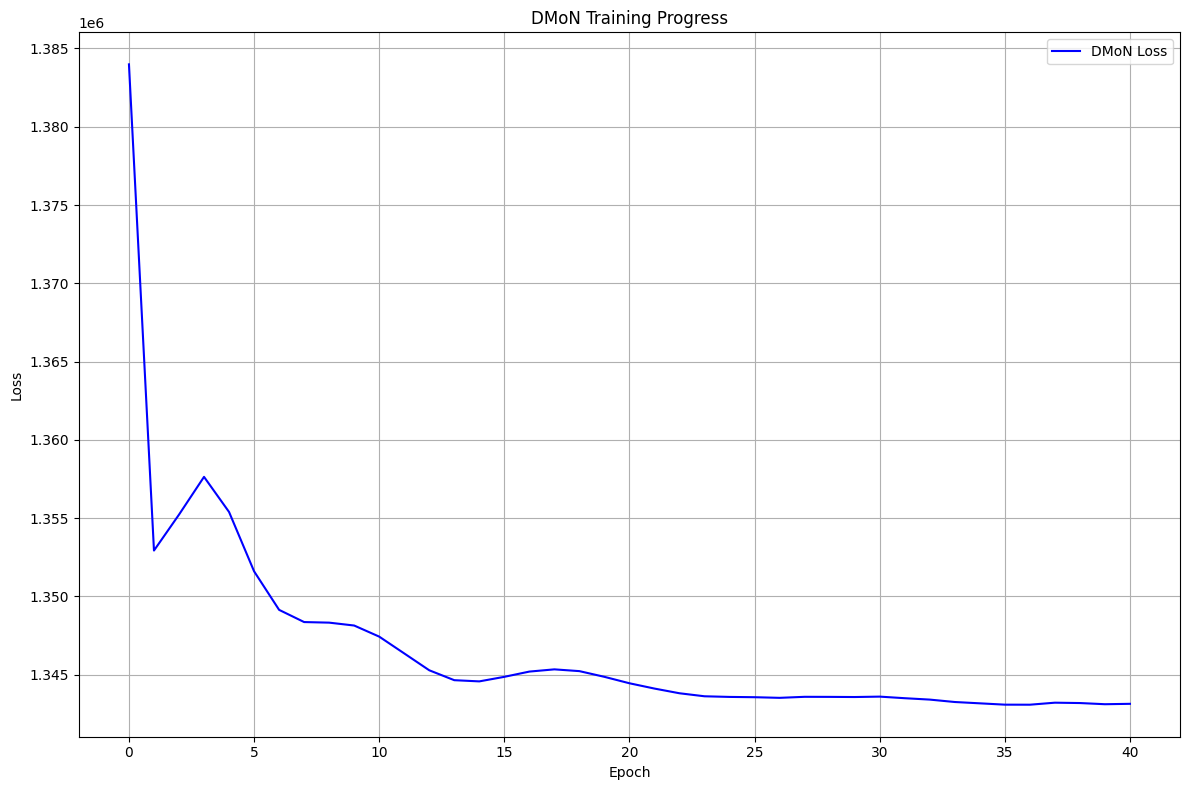

In [11]:
plot_loss(dmon_mixed_losses, "Mixed DMoN Training Progress")
plot_loss(loss_history, "DMoN Training Progress")

In [12]:
if __name__ == "__main__":    
    G, subreddit_graph, subreddit_names = load_subreddit_embeddings()
    subreddit_adjacency = subreddit_graph.toarray()
    num_clusters_subreddits = 20
    subreddit_features = extract_graph_features(G)
    kmeans_subreddit_labels = kmeans_clustering(subreddit_features, num_clusters_subreddits)
    hdbscan_subreddit_labels = hdbscan_clustering(subreddit_features, min_cluster_size=10)
    louvain_subreddit_labels = louvain_clustering(G)
    
    G_subreddits = nx.from_numpy_array(subreddit_adjacency)

    #dmon_graph_labels, dmon_graph_model, dmon_graph_losses = train_dmon_graph(G, num_clusters_subreddits,epochs=41)
    dmon_mixed_subreddit_labels, dmon_mixed_model, dmon_subreddit_mixed_losses = train_dmon_graph_mixed(G,structural_features, num_clusters_subreddits,epochs=10)
    dmon_subreddit_labels, dmon_model, dmon_subreddit_loss_history = train_dmon(subreddit_features, csr_matrix(subreddit_adjacency), num_clusters_subreddits,epochs=41)

    #export_gml(G, dmon_labels, hyperlink_nodes, "gephi_exports/hyperlink/dmon_clusters.gml")
    #export_gml(G, kmeans_labels, hyperlink_nodes, "gephi_exports/hyperlink/kmeans_clusters.gml")
    #export_gml(G, hdbscan_labels, hyperlink_nodes, "gephi_exports/hyperlink/hdbscan_clusters.gml")
    #export_gml(G, louvain_labels,hyperlink_nodes, "gephi_exports/hyperlink/louvain_communities.gml")

Calculating Network Features...
Features Calculation Complete!


c:\Users\Proprio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch 0, Loss: 195747.7658
Epoch 5, Loss: 195134.7426
False


Training DMoN:   2%|▏         | 1/41 [00:00<00:16,  2.35it/s]

Epoch 0, Loss: 1816710.5000


Training DMoN:  51%|█████     | 21/41 [00:08<00:07,  2.52it/s]

Epoch 20, Loss: 1051679.8750


Training DMoN: 100%|██████████| 41/41 [00:16<00:00,  2.47it/s]

Epoch 40, Loss: 1032857.3750


In [13]:
print("Hyperlink Network Results")
print("DMoN vs. Louvain:", evaluate_clustering(dmon_subreddit_labels, louvain_subreddit_labels))
print("Graph DMoN vs. Louvain:", evaluate_clustering(dmon_mixed_subreddit_labels, louvain_subreddit_labels))
print("Graph DMoN Graph vs. DMoN:", evaluate_clustering(dmon_mixed_subreddit_labels, dmon_subreddit_labels))

Hyperlink Network Results
DMoN vs. Louvain: {'AMI': 0.06440631644125329, 'ARI': 0.022489068960209482}
Graph DMoN vs. Louvain: {'AMI': 0.04774872468896197, 'ARI': 0.018462997378037815}
Graph DMoN Graph vs. DMoN: {'AMI': 0.015103630070006266, 'ARI': 0.008865421869024465}


In [28]:
if True:
    kmeans_mod   = compute_modularity(G, kmeans_subreddit_labels)
    kmeans_cond  = compute_conductance(G, kmeans_subreddit_labels)

    hdbscan_mod  = compute_modularity(G, kmeans_subreddit_labels)
    hdbscan_cond = compute_conductance(G, kmeans_subreddit_labels)

    dmon_mod     = compute_modularity(G, dmon_subreddit_labels)
    dmon_cond    = compute_conductance(G, dmon_subreddit_labels)

    #graph_dmon_mod  = compute_modularity(G, dmon_graph_labels)
    #graph_dmon_cond = compute_conductance(G, dmon_graph_labels)

    mixed_dmon_mod  = compute_modularity(G, dmon_mixed_subreddit_labels)
    mixed_dmon_cond = compute_conductance(G, dmon_mixed_subreddit_labels)

    lou_mod      = compute_modularity(G, louvain_subreddit_labels)
    lou_cond     = compute_conductance(G, louvain_subreddit_labels)

    # Collect everything into a list of rows:
    rows = [
        ["K-means",   kmeans_mod,   kmeans_cond      ],
        ["HDBSCAN",   hdbscan_mod,  hdbscan_cond     ],
        ["DMoN",      dmon_mod,     dmon_cond        ],
        #["GraphDMoN", graph_dmon_mod, graph_dmon_cond],
        ["MixedDMoN", mixed_dmon_mod, mixed_dmon_cond],
        ["Louvain",   lou_mod,      lou_cond,        ]
    ]

    df_results = pd.DataFrame(rows, columns=["Method", "Modularity","Conductance"])
    print(df_results)

IndexError: index 51277 is out of bounds for axis 0 with size 51277

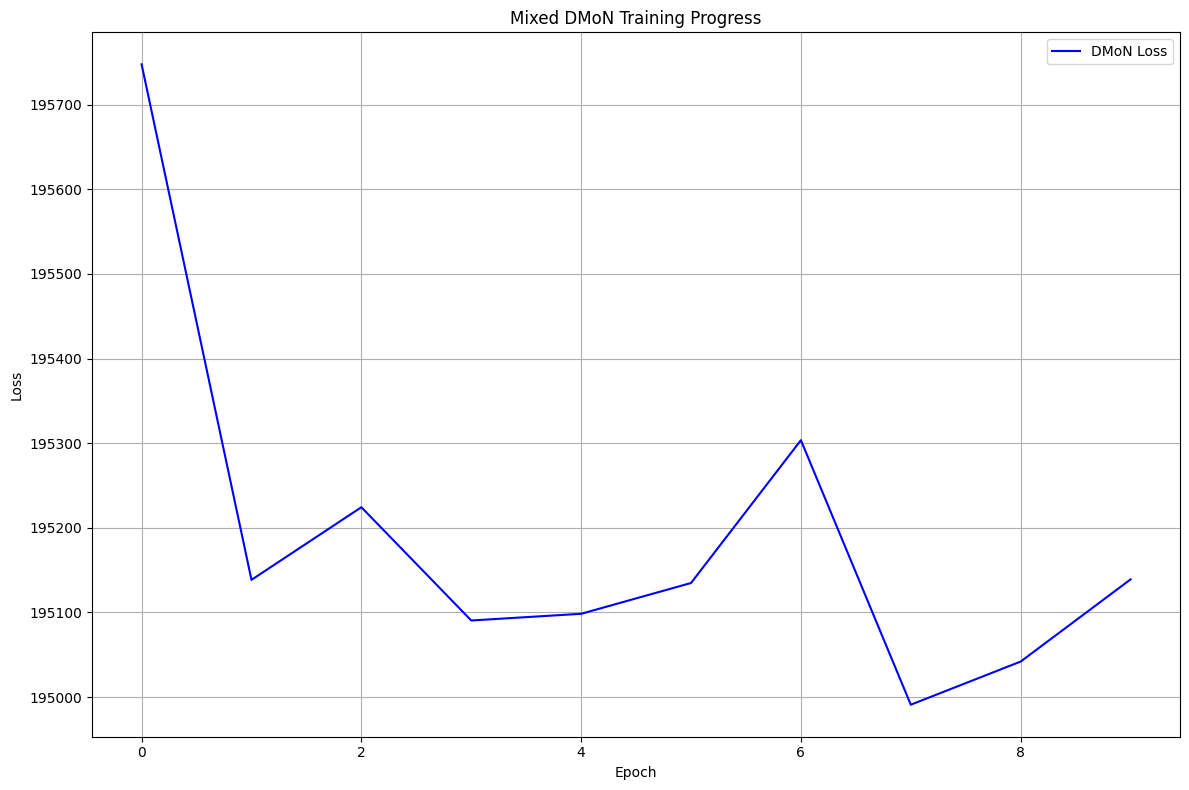

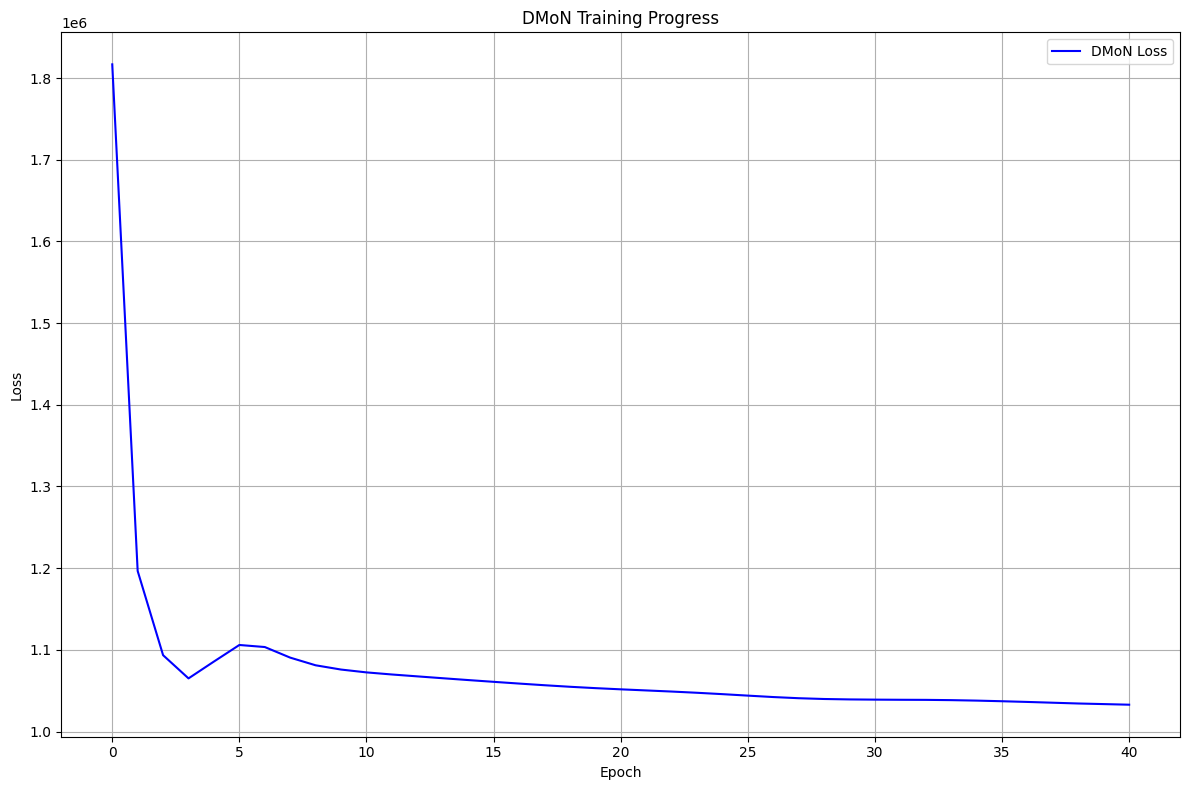

In [15]:
#plot_loss(dmon_graph_losses, "Graph DMoN Training Progress")
plot_loss(dmon_subreddit_mixed_losses, "Mixed DMoN Training Progress")
plot_loss(dmon_subreddit_loss_history, "DMoN Training Progress")

In [16]:
if __name__ == "__main__":    
    print("\n===== Processing Reddit User Embeddings Network =====\n")
    G, user_adj, user_names = load_user_embeddings()
    user_features = extract_graph_features(G)   
    print("user embeddings loaded")

    num_clusters_users = 20

    print("User features shape:", user_features.shape)
    kmeans_user_labels = kmeans_clustering(user_features, num_clusters_users)
    print("user k-means done")
    hdbscan_user_labels = hdbscan_clustering(user_features, num_clusters_users)
    print("user hdbscan done")
    louvain_user_labels = louvain_clustering(G)

    #dmon_graph_user_labels, dmon_graph_model, dmon_graph_losses = train_dmon_graph(G, num_clusters_users,epochs=41)
    dmon_mixed_user_labels, dmon_mixed_model, dmon_mixed_user_losses = train_dmon_graph_mixed(G,user_features, num_clusters_users,epochs=20)
    dmon_user_labels, dmon_model, dmon_user_loss_history = train_dmon(user_features, csr_matrix(user_adj), num_clusters_users,epochs=41)

    export_gml(G, dmon_labels, hyperlink_nodes, "gephi_exports/hyperlink/dmon_clusters.gml")
    #export_gml(G, kmeans_labels, hyperlink_nodes, "gephi_exports/hyperlink/kmeans_clusters.gml")
    #export_gml(G, hdbscan_labels, hyperlink_nodes, "gephi_exports/hyperlink/hdbscan_clusters.gml")
    #export_gml(G, louvain_labels,hyperlink_nodes, "gephi_exports/hyperlink/louvain_communities.gml")




===== Processing Reddit User Embeddings Network =====

Calculating Network Features...
Features Calculation Complete!
user embeddings loaded
User features shape: (118380, 4)
user k-means done


c:\Users\Proprio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


user hdbscan done
Epoch 0, Loss: 186533.0568
Epoch 5, Loss: 174589.3991
Epoch 10, Loss: 174747.9425
Epoch 15, Loss: 174719.4778
False


Training DMoN:   2%|▏         | 1/41 [00:00<00:39,  1.01it/s]

Epoch 0, Loss: 2461676.5000


Training DMoN:  51%|█████     | 21/41 [00:19<00:18,  1.07it/s]

Epoch 20, Loss: 2366556.7500


Training DMoN: 100%|██████████| 41/41 [00:38<00:00,  1.07it/s]

Epoch 40, Loss: 2365253.0000


In [29]:
print("User Embeddings Network Results")
print("DMoN vs. Louvain:", evaluate_clustering(dmon_user_labels, louvain_user_labels))
print("Mixed DMoN vs. Louvain:", evaluate_clustering(dmon_mixed_user_labels, louvain_user_labels))
print("Mixed DMoN Graph vs. DMoN:", evaluate_clustering(dmon_mixed_user_labels, dmon_user_labels))

User Embeddings Network Results
DMoN vs. Louvain: {'AMI': 0.014743649099464086, 'ARI': 0.0053516715109882115}
Mixed DMoN vs. Louvain: {'AMI': 0.06247365916570659, 'ARI': 0.014481094016847117}
Mixed DMoN Graph vs. DMoN: {'AMI': 0.015355600076649165, 'ARI': 0.0011367893190040322}


In [31]:
if True:    
    kmeans_mod   = compute_modularity(G, kmeans_user_labels)
    kmeans_cond  = compute_conductance(G, kmeans_user_labels)

    hdbscan_mod  = compute_modularity(G, hdbscan_user_labels)
    hdbscan_cond = compute_conductance(G, hdbscan_user_labels)

    dmon_mod     = compute_modularity(G, dmon_user_labels)
    dmon_cond    = compute_conductance(G, dmon_user_labels)

    #graph_dmon_mod  = compute_modularity(G, dmon_graph_labels)
    #graph_dmon_cond = compute_conductance(G, dmon_graph_labels)

    mixed_dmon_mod  = compute_modularity(G, dmon_mixed_user_labels)
    mixed_dmon_cond = compute_conductance(G, dmon_mixed_user_labels)

    lou_mod      = compute_modularity(G, louvain_user_labels)
    lou_cond     = compute_conductance(G, louvain_user_labels)

    rows = [
        ["K-means",   kmeans_mod,   kmeans_cond      ],
        ["HDBSCAN",   hdbscan_mod,  hdbscan_cond     ],
        ["DMoN",      dmon_mod,     dmon_cond        ],
        #["GraphDMoN", graph_dmon_mod, graph_dmon_cond],
        ["MixedDMoN", mixed_dmon_mod, mixed_dmon_cond],
        ["Louvain",   lou_mod,      lou_cond,        ]
    ]

    df_results = pd.DataFrame(rows, columns=["Method", "Modularity","Conductance"])

    print(df_results)

      Method  Modularity  Conductance
0    K-means   -0.038654     0.976443
1    HDBSCAN   -0.075418     0.999468
2       DMoN    0.016386     0.905079
3  MixedDMoN    0.077979     0.905924
4    Louvain    0.637178     0.265981


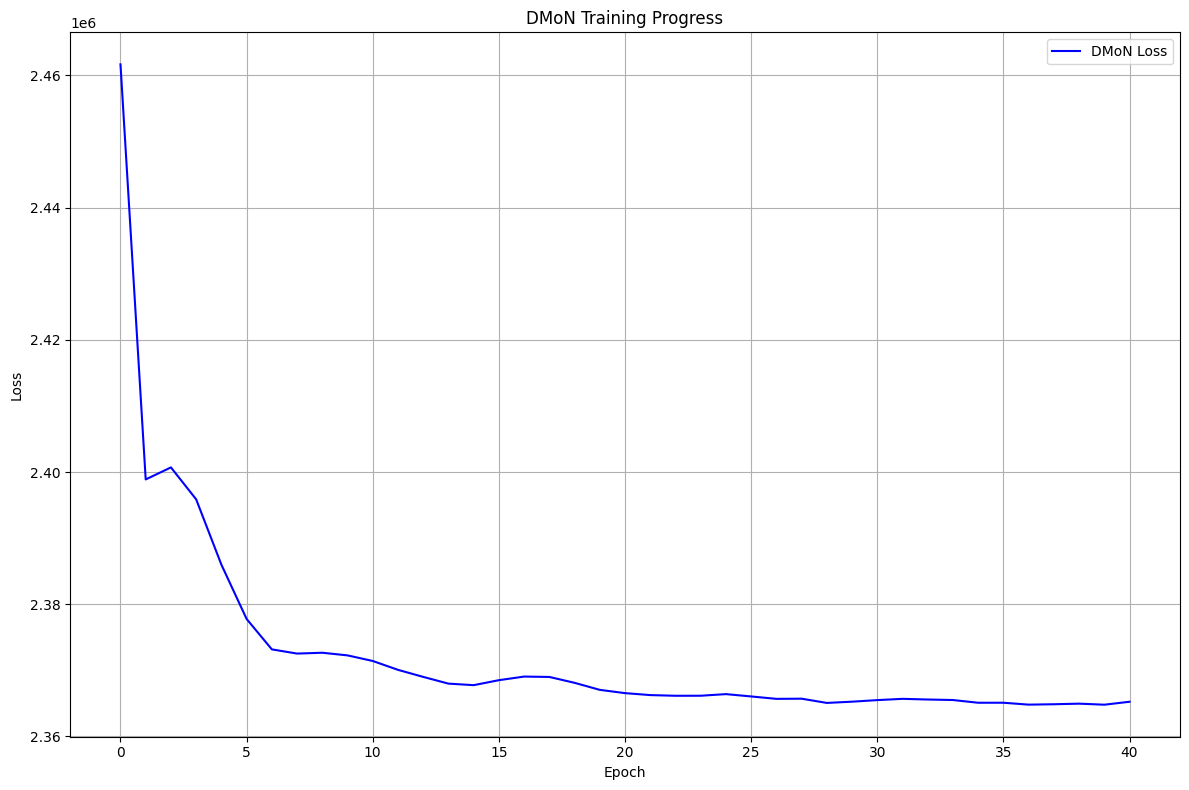

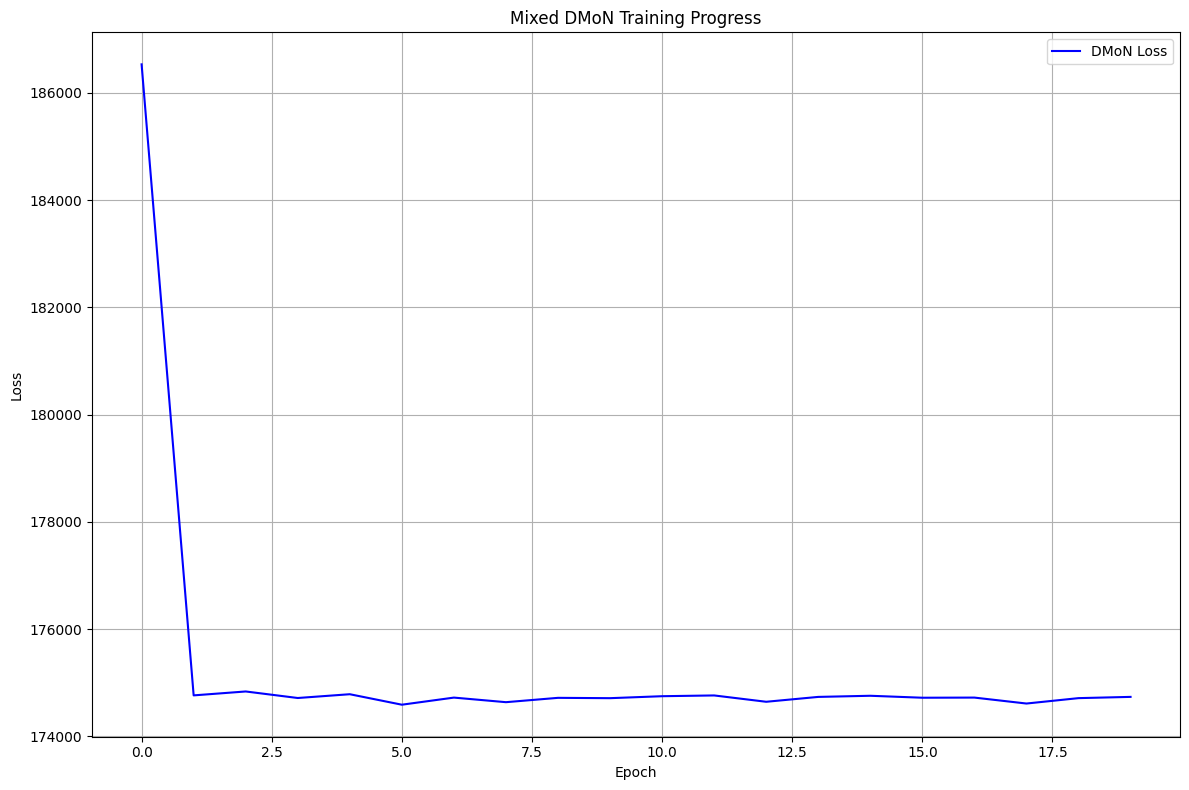

In [32]:
plot_loss(dmon_user_loss_history, "DMoN Training Progress")
plot_loss(dmon_mixed_user_losses, "Mixed DMoN Training Progress")